In [592]:
import numpy as np 
import pandas as pd
import os
import xgboost as xgb
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline 


# Read data

In [593]:
f='data/'
   

sales_train         = pd.read_csv( f + 'sales_train.csv.gz')
test                = pd.read_csv( f + 'test.csv.gz')
shops               = pd.read_csv( f + 'shops.csv')
sample_submission   = pd.read_csv( f + 'sample_submission.csv.gz')
items               = pd.read_csv( f + 'items.csv')
item_categories     = pd.read_csv( f + 'item_categories.csv')

In [594]:
# for df in [sales_train,test,shops,sample_submission,items,item_categories]:
# 	display(df.head(5))
for df in [sales_train,test]:
    display(df.head(5))


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


We can see that train and test data-sets are different. 
* Train is the list of unique transactions
* test is the list of unique shop-item pairs

### Compute all shops/items combinations inside each date_block

In [595]:
from itertools import product

index_cols = ['shop_id', 'item_id', 'date_block_num']

#
grid_list = []
for block_num in sales_train['date_block_num'].unique():
    cur_shops = sales_train.loc[sales_train['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales_train.loc[sales_train['date_block_num'] == block_num, 'item_id'].unique()
    iterator  = product( *[cur_shops, cur_items, [block_num] ])
    grid_list.append( np.array(list(iterator),dtype='int32') )

grid = pd.DataFrame( np.vstack(grid_list), 
                     columns = index_cols,
                     dtype=np.int32)

In [596]:
grid.sample(20)

,shop_id,item_id,date_block_num
2260350,52,5303,5
4069996,51,17540,10
10871003,9,8789,33
8791193,35,4067,25
4366554,51,16505,11
601043,6,16608,1
1417361,31,17064,3
1643671,45,17310,4
6078459,55,17933,16
4610393,30,5868,12


# EDA

In [597]:
for df in [sales_train,test,shops,sample_submission,items,item_categories]:
	display(df.head(5))


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


## Shops exploration and data leakage

In [598]:
display(shops)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [599]:
#This addresses are seems to be the same
for i in [10,11]:
    print(shops.loc[i].shop_name)
print('-'*20)
shops.at[10,'shop_name']=shops.loc[11,'shop_name']

#Remove ! sign from city name
shops.shop_name = shops.shop_name.apply(lambda x: x.replace('!',''))

   

# Group to e-shops into single category
print(shops.loc[55].shop_name)
print(shops.loc[12].shop_name)
shops.at[55,'shop_name']='Интернет-магазин '+shops.at[55,'shop_name']

display(shops)


Жуковский ул. Чкалова 39м?
Жуковский ул. Чкалова 39м²
--------------------
Цифровой склад 1С-Онлайн
Интернет-магазин ЧС


,shop_name,shop_id
0,"Якутск Орджоникидзе, 56 фран",0
1,"Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [600]:
from sklearn.preprocessing import LabelEncoder
shops['shop_city'] = shops['shop_name'].str.split().str[0].str.strip()

# Parse results of city parser, normalize city names
replace_table=[
     ['РостовНаДону', 'Ростов-на-Дону',]
    ,['СПб'         , 'Санкт-Петербург']
    ,['Адыгея'      , 'Краснодар'] # Адыгея ТЦ "Мега" locates in Krasnodar City
    ,['Н.Новгород'  , 'Нижний Новгород']
    ,['Сергиев'     ,'Сергиев Посад'] # Parsing error, fix manually
]
for w in replace_table:
    shops.shop_city = shops.shop_city.apply(lambda x: x.replace(w[0],w[1]))
    
shops['shop_city_id'] = LabelEncoder().fit_transform(shops['shop_city'])
display(shops)


,shop_name,shop_id,shop_city,shop_city_id
0,"Якутск Орджоникидзе, 56 фран",0,Якутск,28
1,"Якутск ТЦ ""Центральный"" фран",1,Якутск,28
2,"Адыгея ТЦ ""Мега""",2,Краснодар,10
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,0
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,1
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,2
6,"Воронеж (Плехановская, 13)",6,Воронеж,3
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,3
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,3
9,Выездная Торговля,9,Выездная,4


In [601]:
print('Unique shops  %2d'%len(shops.shop_name.unique()))
print('Unique cities %2d'%len(shops.shop_city.unique()))


Unique shops  59
Unique cities 30


As addresses and cities are not anonimized, we can get more information, if grab some more information from outside competition data-set.

Download Russian Cities database in JSON https://github.com/pensnarik/russian-cities

In [602]:
ru_cities = pd.read_json('russian-cities.json',encoding='utf-8')
display(ru_cities.head(10))
city2pop  = dict(zip(ru_cities.name, ru_cities.population))
city2subj = dict(zip(ru_cities.name, ru_cities.subject))


,coords,district,name,population,subject
0,"{'lat': '52.65', 'lon': '90.08333'}",Сибирский,Абаза,17111,Хакасия
1,"{'lat': '53.71667', 'lon': '91.41667'}",Сибирский,Абакан,186619,Хакасия
2,"{'lat': '53.68333', 'lon': '53.65'}",Приволжский,Абдулино,20663,Оренбургская область
3,"{'lat': '44.86667', 'lon': '38.16667'}",Южный,Абинск,34926,Краснодарский край
4,"{'lat': '55.9', 'lon': '53.93333'}",Приволжский,Агидель,16365,Башкортостан
5,"{'lat': '56.51667', 'lon': '52.98333'}",Приволжский,Агрыз,19299,Татарстан
6,"{'lat': '44.884525', 'lon': '39.19202'}",Южный,Адыгейск,12689,Адыгея
7,"{'lat': '54.85', 'lon': '53.06667'}",Приволжский,Азнакаево,34859,Татарстан
8,"{'lat': '47.1', 'lon': '39.41667'}",Южный,Азов,82882,Ростовская область
9,"{'lat': '51.16667', 'lon': '90.6'}",Сибирский,Ак-Довурак,13469,Тыва


In [603]:
shops['shop_city_pop' ] = shops['shop_city'].map(city2pop).fillna(-1)
shops['shop_city_subj'] = shops['shop_city'].map(city2subj).fillna('not-a-city')
shops['shop_city_subj_id'] = LabelEncoder().fit_transform(shops['shop_city_subj'])

display(shops)

,shop_name,shop_id,shop_city,shop_city_id,shop_city_pop,shop_city_subj,shop_city_subj_id
0,"Якутск Орджоникидзе, 56 фран",0,Якутск,28,269486.0,Якутия,21
1,"Якутск ТЦ ""Центральный"" фран",1,Якутск,28,269486.0,Якутия,21
2,"Адыгея ТЦ ""Мега""",2,Краснодар,10,744933.0,Краснодарский край,6
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,0,215353.0,Московская область,10
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,1,314436.0,Волгоградская область,2
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,2,301642.0,Вологодская область,3
6,"Воронеж (Плехановская, 13)",6,Воронеж,3,889680.0,Воронежская область,4
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,3,889680.0,Воронежская область,4
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,3,889680.0,Воронежская область,4
9,Выездная Торговля,9,Выездная,4,-1.0,not-a-city,0


In [604]:
assert 3==len(shops[ shops['shop_city_pop' ] == -1])

Cool! So we generated new heuristic features from geography, which may be helpful for classifier
* Shop City
* Shop City population, no we can aggregate data for small cities and big one
* Shop City subject, which also may be usefull. 

## Explore categories

### Here we also will create meta-categories from categories names

In [605]:
pd.set_option("display.max_rows", 101)

# Create meta-categories, buy just splitting left word from category name

# As splitter use sign "(" or "-"

item_categories['item_metacategory_name'] = item_categories['item_category_name'].str.split('-|\\(').str[0].str.strip()
item_categories['item_metacategory_id']   = LabelEncoder().fit_transform(item_categories['item_metacategory_name'])

display(item_categories)

print('Unique categories      %2d'%len(item_categories.item_category_name.unique()))
print('Unique meta-categories %2d'%len(item_categories.item_metacategory_name.unique()))


,item_category_name,item_category_id,item_metacategory_name,item_metacategory_id
0,PC - Гарнитуры/Наушники,0,PC,0
1,Аксессуары - PS2,1,Аксессуары,1
2,Аксессуары - PS3,2,Аксессуары,1
3,Аксессуары - PS4,3,Аксессуары,1
4,Аксессуары - PSP,4,Аксессуары,1
5,Аксессуары - PSVita,5,Аксессуары,1
6,Аксессуары - XBOX 360,6,Аксессуары,1
7,Аксессуары - XBOX ONE,7,Аксессуары,1
8,Билеты (Цифра),8,Билеты,2
9,Доставка товара,9,Доставка товара,3


Unique categories      84
Unique meta-categories 18


## Explore items

In [ ]:
items.sample(100)

,item_name,item_id,item_category_id
18896,СМУРФИКИ. ПЕРВОЕ РОЖДЕСТВО КРОШКИ СМУРФИКА (р...,18896,40
10935,ДЕТЯМ Ударцев Виктор Новогодняя дискотека,10935,55
8358,АРИЯ Новая коллекция 2,8358,55
18426,СБ. Премия МУЗ-ТВ 2013 Перезагрузка,18426,55
9050,БРОНЗОВАЯ ПТИЦА (регион),9050,40
115,1С:Аудио. Музыка природы (Jewel),115,57
2619,DEPECHE MODE Speak And Spell SACD+DVD (фирм.),2619,56
4005,JOHN ELTON One Night Only Greatest Hits DVD,4005,59
11914,ИГРА В ИМИТАЦИЮ (BD),11914,37
13394,"Комплект ""Microsoft Xbox 360 250GB"" + ""Xbox 36...",13394,15


From forum we know that naive TF_IDF features are not useful and it makes sense - here we have very specific set of strings.

We should use instead some more heuristic, prior-knowledge features.

Let's have a look, can make a features based on games name

In [ ]:


games = ['Need for Speed Most Wanted',
        'Call of Duty: Advanced Warfare',
         'Warhammer 40000',
        'Grand Theft Auto IV']
for g in games:
    df  = items[items['item_name'].str.contains(g)]
    display(df)
    print('Found %d verisions of %s'%(len(df),g))

,item_name,item_id,item_category_id
5228,Need for Speed Most Wanted (Classics) (рус.в.)...,5228,30
5229,"Need for Speed Most Wanted (EA) [PC, Цифровая ...",5229,31
5230,"Need for Speed Most Wanted [Android, Цифровая ...",5230,26


Found 3 verisions of Need for Speed Most Wanted


,item_name,item_id,item_category_id
2282,"Call of Duty: Advanced Warfare [PC, Цифровая в...",2282,31
2283,"Call of Duty: Advanced Warfare [PC, русская ве...",2283,30
2284,"Call of Duty: Advanced Warfare [PS3, русская в...",2284,19
2285,"Call of Duty: Advanced Warfare [PS4, русская в...",2285,20
2286,"Call of Duty: Advanced Warfare [Xbox 360, русс...",2286,23
2287,"Call of Duty: Advanced Warfare [Xbox One, русс...",2287,24
2288,Call of Duty: Advanced Warfare. Atlas Limited ...,2288,28
2289,Call of Duty: Advanced Warfare. Atlas Limited ...,2289,20
2290,Call of Duty: Advanced Warfare. Atlas Limited ...,2290,24
2291,Call of Duty: Advanced Warfare. Atlas Pro Edit...,2291,20


Found 22 verisions of Call of Duty: Advanced Warfare


,item_name,item_id,item_category_id
7569,WARHAMMER 40000 ACCESSORIES: Warhammer 40000 R...,7569,64
7777,"Warhammer 40000 Dawn of War. Retribution [PC, ...",7777,30
7778,Warhammer 40000 Dawn of War. Retribution. Косм...,7778,28
7779,Warhammer 40000. Dawn of War Soulstorm (PC-DVD...,7779,30
13154,Классика жанра. Warhammer 40000 Dawn of War. R...,13154,30
19296,Сборник Premium Games. Warhammer 40000. Dawn o...,19296,30


Found 6 verisions of Warhammer 40000


,item_name,item_id,item_category_id
3713,"Grand Theft Auto IV (Classics) [Xbox 360, русс...",3713,23
3714,Grand Theft Auto IV (full eng) (PS3) (Case Set),3714,19
3715,"Grand Theft Auto IV (СофтКлаб) [PC, Цифровая в...",3715,31
3716,"Grand Theft Auto IV Complete Edition [PS3, анг...",3716,19
3717,Grand Theft Auto IV Complete Edition [Xbox 360...,3717,23
3718,Grand Theft Auto IV DVD,3718,30
3719,"Grand Theft Auto IV. Полное издание [PC, Jewel...",3719,30


Found 7 verisions of Grand Theft Auto IV


In [ ]:
# Read list of games from Wikipedia

from wikitables import import_tables
import string
idx=list(string.ascii_uppercase)
idx.append('Numerical')
game_list=[]
for i in idx:
    if i=='A':
        page_name='List_of_PC_games'
    else:
        page_name='List_of_PC_games_(%s)'%i
    
    tables = import_tables(page_name) 
    if i=='Numerical':
        filed='Title'
    else:
        filed='Name'
        
    game_list+=[str(r[filed]) for r in tables[0].rows] 
print('Total games: %3d'%len(game_list))

List of PC games (R)[0][22]: dropping field from unknown column: Episode 1
List of PC games (R)[0][22]: dropping field from unknown column: Episode 2
List of PC games (R)[0][22]: dropping field from unknown column: Episode 3
List of PC games (R)[0][22]: dropping field from unknown column: Episode 4
List of PC games (R)[0][22]: dropping field from unknown column: 2015 02 24
List of PC games (R)[0][22]: dropping field from unknown column: 2015 03 03
List of PC games (R)[0][22]: dropping field from unknown column: 2015 03 10
List of PC games (R)[0][22]: dropping field from unknown column: 2015 03 17
List of PC games (R)[0][23]: missing field for column [Operating system(s)]
List of PC games (R)[0][23]: missing field for column [Date released]
List of PC games (R)[0][34]: dropping field from unknown column: +
List of PC games (R)[0][34]: dropping field from unknown column: Windows, Playstation 4
List of PC games (R)[0][34]: dropping field from unknown column: Xbox One
List of PC games (R)[

Total games: 862


In [ ]:
all_games = pd.DataFrame(game_list,columns=['game_name'])
all_games.sample(20)


,game_name
284,Driver: San Francisco
693,The Sims: House Party
483,Metal Gear 2: Solid Snake
677,The Sims 2: Bon Voyage
605,Saints Row: The Third
451,Legends of Callasia
523,Nickelodeon Party Blast
6,Ace Lightning
274,Dragon Age: Origins
742,Universe Sandbox


In [ ]:
games = ['Need for Speed Most Wanted',
        'Call of Duty: Advanced Warfare',
         'Warhammer 40000',
        'Grand Theft Auto IV']

for g in games:
    print(all_games[all_games['game_name'].str.contains(g)])


Empty DataFrame
Columns: [game_name]
Index: []
Empty DataFrame
Columns: [game_name]
Index: []
Empty DataFrame
Columns: [game_name]
Index: []
               game_name
377  Grand Theft Auto IV


Can think about it later. Possible solution - find popular 3 grams in games list.

## Train datatype exploration

In [ ]:
sales_train.sample(20)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1202472,16.12.2013,11,54,17982,149.0,1.0
954452,04.10.2013,9,31,14389,149.0,1.0
1687841,20.05.2014,16,37,71,499.0,1.0
712895,21.07.2013,6,46,10077,149.0,1.0
80751,26.01.2013,0,56,16623,399.0,3.0
2051549,13.10.2014,21,4,1856,1499.0,1.0
2717761,27.06.2015,29,56,1307,349.0,1.0
1171727,30.12.2013,11,16,10815,149.0,1.0
238859,12.03.2013,2,31,6660,419.3,1.0
2799571,18.08.2015,31,48,11920,3999.0,1.0


## First, have a look on outliers

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
885138,17.09.2013,8,12,11365,59200.0,1.0
1163158,13.12.2013,11,12,6066,307980.0,1.0
1488135,20.03.2014,14,25,13199,50999.0,1.0


,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75
11365,Доставка (EMS),11365,9
13199,Коллекционные шахматы (Властелин Колец),13199,69


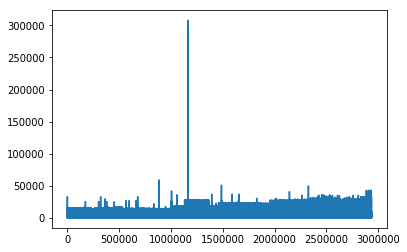

In [ ]:
sales_train.item_price.plot()
price_thr = 50000
display(sales_train[sales_train['item_price']>price_thr])
idx = list(sales_train[sales_train['item_price']>price_thr].item_id)

items.loc[items['item_id'].isin(idx)]

In [ ]:
display(items[items['item_name'].str.contains('Radmin 3')])

,item_name,item_id,item_category_id
6065,Radmin 3 - 1 лиц.,6065,75
6066,Radmin 3 - 522 лиц.,6066,75


In [ ]:
# Print all RADMIN items in sales

display(sales_train[sales_train['item_id'].isin([6065,6066])])

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
291238,21.03.2013,2,22,6065,1299.0,1.0
291260,22.03.2013,2,22,6065,1299.0,1.0
318708,11.03.2013,2,25,6065,1299.0,1.0
370177,18.04.2013,3,12,6065,1299.0,1.0
375067,06.04.2013,3,6,6065,1299.0,1.0
379230,12.04.2013,3,22,6065,1299.0,1.0
379232,20.04.2013,3,22,6065,1299.0,2.0
487026,05.05.2013,4,54,6065,1299.0,1.0
542238,07.06.2013,5,29,6065,1299.0,1.0
679923,29.07.2013,6,22,6065,1299.0,1.0


It simple - intstead of 522 licenses of Radmin we have single item "522 licenses"
We can manually proceed it

In [ ]:
radmin_id     = 1163158
sales_train.at[radmin_id,'item_id']     = 6065
sales_train.at[radmin_id,'item_price']  = int(307980/522)
sales_train.at[radmin_id,'item_cnt_day']=  522
display(sales_train[sales_train['item_id'].isin([6065,6066])])

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
291238,21.03.2013,2,22,6065,1299.0,1.0
291260,22.03.2013,2,22,6065,1299.0,1.0
318708,11.03.2013,2,25,6065,1299.0,1.0
370177,18.04.2013,3,12,6065,1299.0,1.0
375067,06.04.2013,3,6,6065,1299.0,1.0
379230,12.04.2013,3,22,6065,1299.0,1.0
379232,20.04.2013,3,22,6065,1299.0,2.0
487026,05.05.2013,4,54,6065,1299.0,1.0
542238,07.06.2013,5,29,6065,1299.0,1.0
679923,29.07.2013,6,22,6065,1299.0,1.0


### Look for outliers by item_count

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,15.01.2015,24,12,20949,4.000000,1000.0
2608040,14.04.2015,27,12,3731,1904.548077,624.0
2851091,30.09.2015,32,55,9249,1702.825746,637.0
2864235,30.09.2015,32,12,9248,1692.526158,669.0
2909818,28.10.2015,33,12,11373,0.908714,2169.0


,item_name,item_id,item_category_id
3731,"Grand Theft Auto V [PC, русские субтитры]",3731,30
9248,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [...",9248,80
9249,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",9249,8
11373,Доставка до пункта выдачи (Boxberry),11373,9
20949,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71


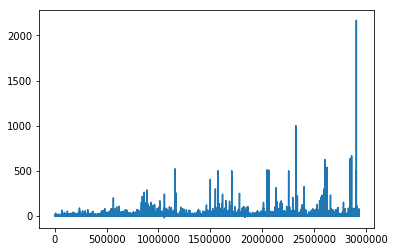

In [ ]:
sales_train.item_cnt_day.plot()
cnt_thr = 600
display(sales_train[sales_train['item_cnt_day']>cnt_thr])
idx = list(sales_train[sales_train['item_cnt_day']>cnt_thr].item_id)

items.loc[items['item_id'].isin(idx)]


Well, we can assume that item count data are reliable

### Calculate revenue by shops

,shop_id,item_revenue,shop_name,shop_city,shop_city_id,shop_city_pop,shop_city_subj,shop_city_subj_id
31,31,2.352170e+08,"Москва ТЦ ""Семеновский""",Москва,13,11514330.0,Москва,9
25,25,2.164806e+08,"Москва ТРК ""Атриум""",Москва,13,11514330.0,Москва,9
28,28,1.597463e+08,"Москва ТЦ ""МЕГА Теплый Стан"" II",Москва,13,11514330.0,Москва,9
42,42,1.519170e+08,"СПб ТК ""Невский Центр""",Санкт-Петербург,20,4848742.0,Санкт-Петербург,16
54,54,1.419397e+08,"Химки ТЦ ""Мега""",Химки,26,207125.0,Московская область,10
27,27,1.406325e+08,"Москва ТЦ ""МЕГА Белая Дача II""",Москва,13,11514330.0,Москва,9
57,57,1.129998e+08,"Якутск Орджоникидзе, 56",Якутск,28,269486.0,Якутия,21
12,12,1.122051e+08,Интернет-магазин ЧС,Интернет-магазин,6,-1.0,not-a-city,0
6,6,9.806745e+07,"Воронеж (Плехановская, 13)",Воронеж,3,889680.0,Воронежская область,4
18,18,8.339270e+07,"Красноярск ТЦ ""Июнь""",Красноярск,11,973826.0,Красноярский край,7


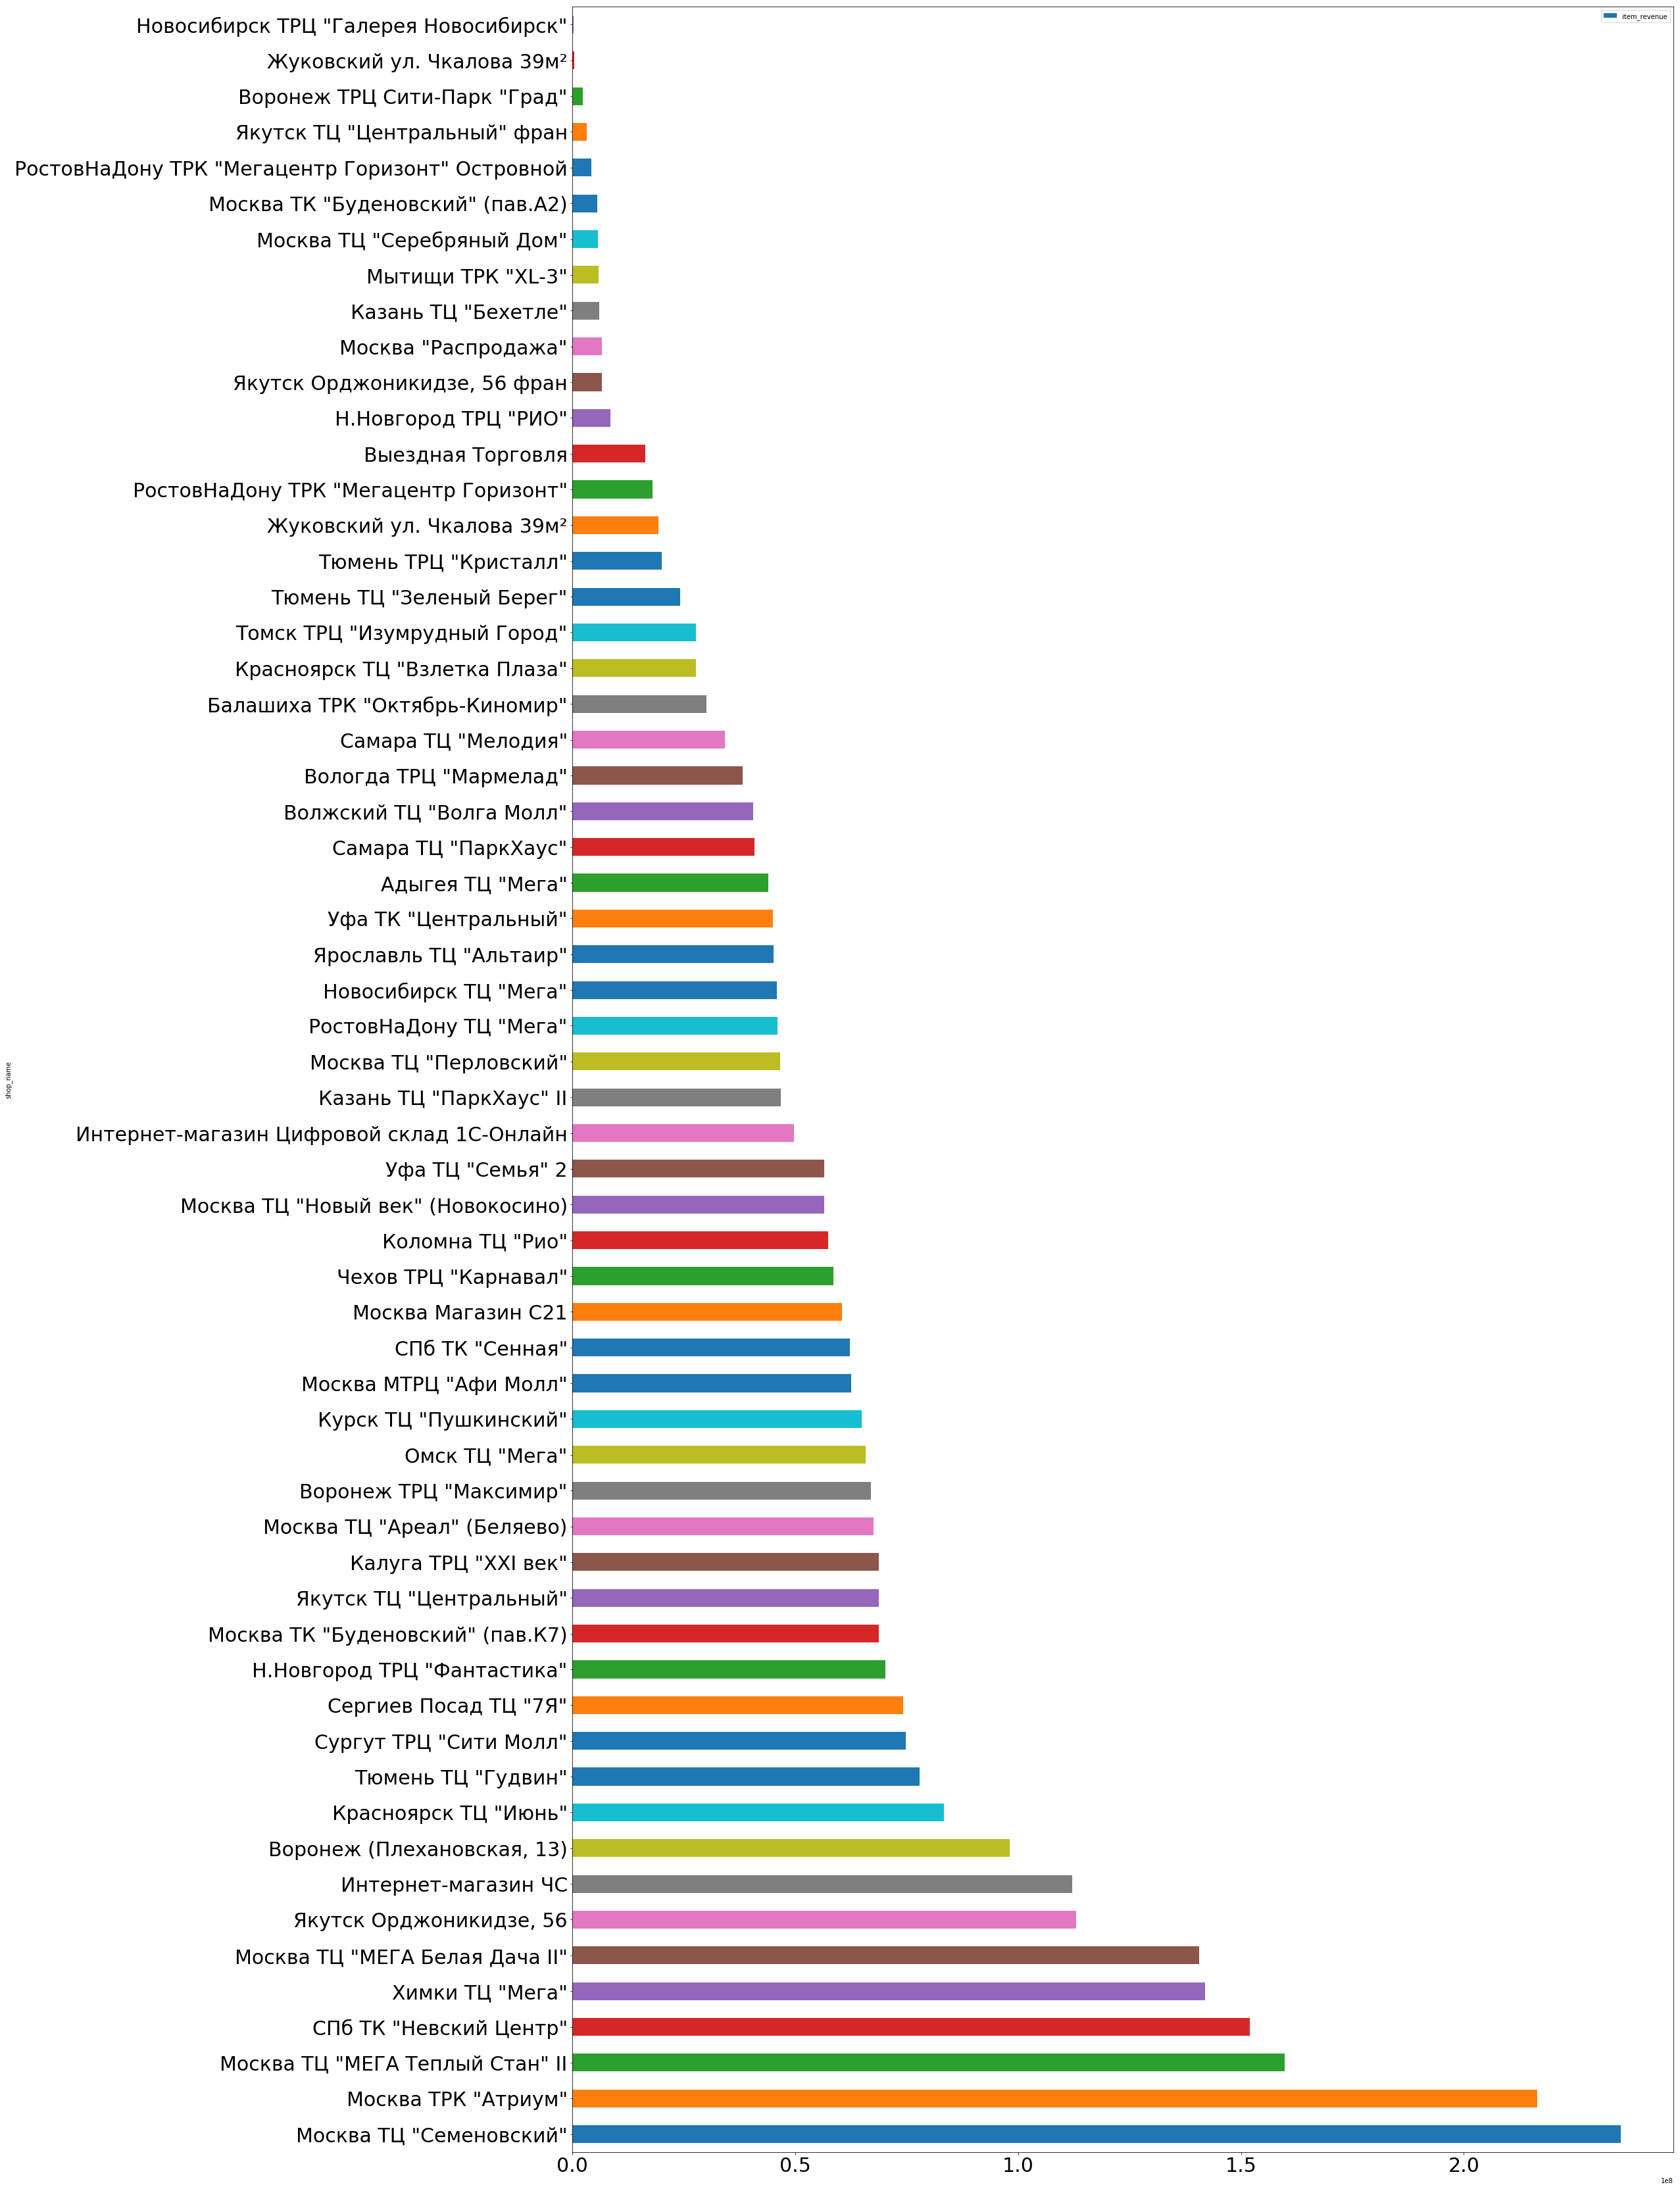

In [ ]:

import numpy as np
sales_train['item_revenue'] = sales_train['item_price'] * sales_train['item_cnt_day']

revenue_by_shops = sales_train['item_revenue'].groupby(sales_train['shop_id']).sum()
revenue_by_shops = pd.merge( pd.DataFrame(revenue_by_shops),
                            shops, how='left', on='shop_id').sort_values(by=['item_revenue'],
                                                                        ascending=False)

max_revenue_shop = revenue_by_shops.loc[revenue_by_shops['item_revenue'].idxmax()]


ax = revenue_by_shops.plot.barh( x = 'shop_name',
                                y='item_revenue',
                                figsize  = (30,60),
                                fontsize = 30)
display(revenue_by_shops)

### Calc revenue by category:

In [ ]:
itemid2cat = dict(zip(items.item_id, items.item_category_id))


,item_category_name,item_category_id,item_metacategory_name,item_metacategory_id,revenue,revenue_log
0,PC - Гарнитуры/Наушники,0,PC,0,2.634000e+02,8.041112
1,Аксессуары - PS2,1,Аксессуары,1,4.310000e+02,8.751544
2,Аксессуары - PS3,2,Аксессуары,1,4.356447e+07,25.376649
3,Аксессуары - PS4,3,Аксессуары,1,6.255353e+07,25.898588
4,Аксессуары - PSP,4,Аксессуары,1,1.332177e+06,20.345354
5,Аксессуары - PSVita,5,Аксессуары,1,6.384949e+06,22.606244
6,Аксессуары - XBOX 360,6,Аксессуары,1,3.822074e+07,25.187852
7,Аксессуары - XBOX ONE,7,Аксессуары,1,1.433048e+07,23.772584
8,Билеты (Цифра),8,Билеты,2,1.930989e+07,24.202837
9,Доставка товара,9,Доставка товара,3,6.538910e+06,22.640619


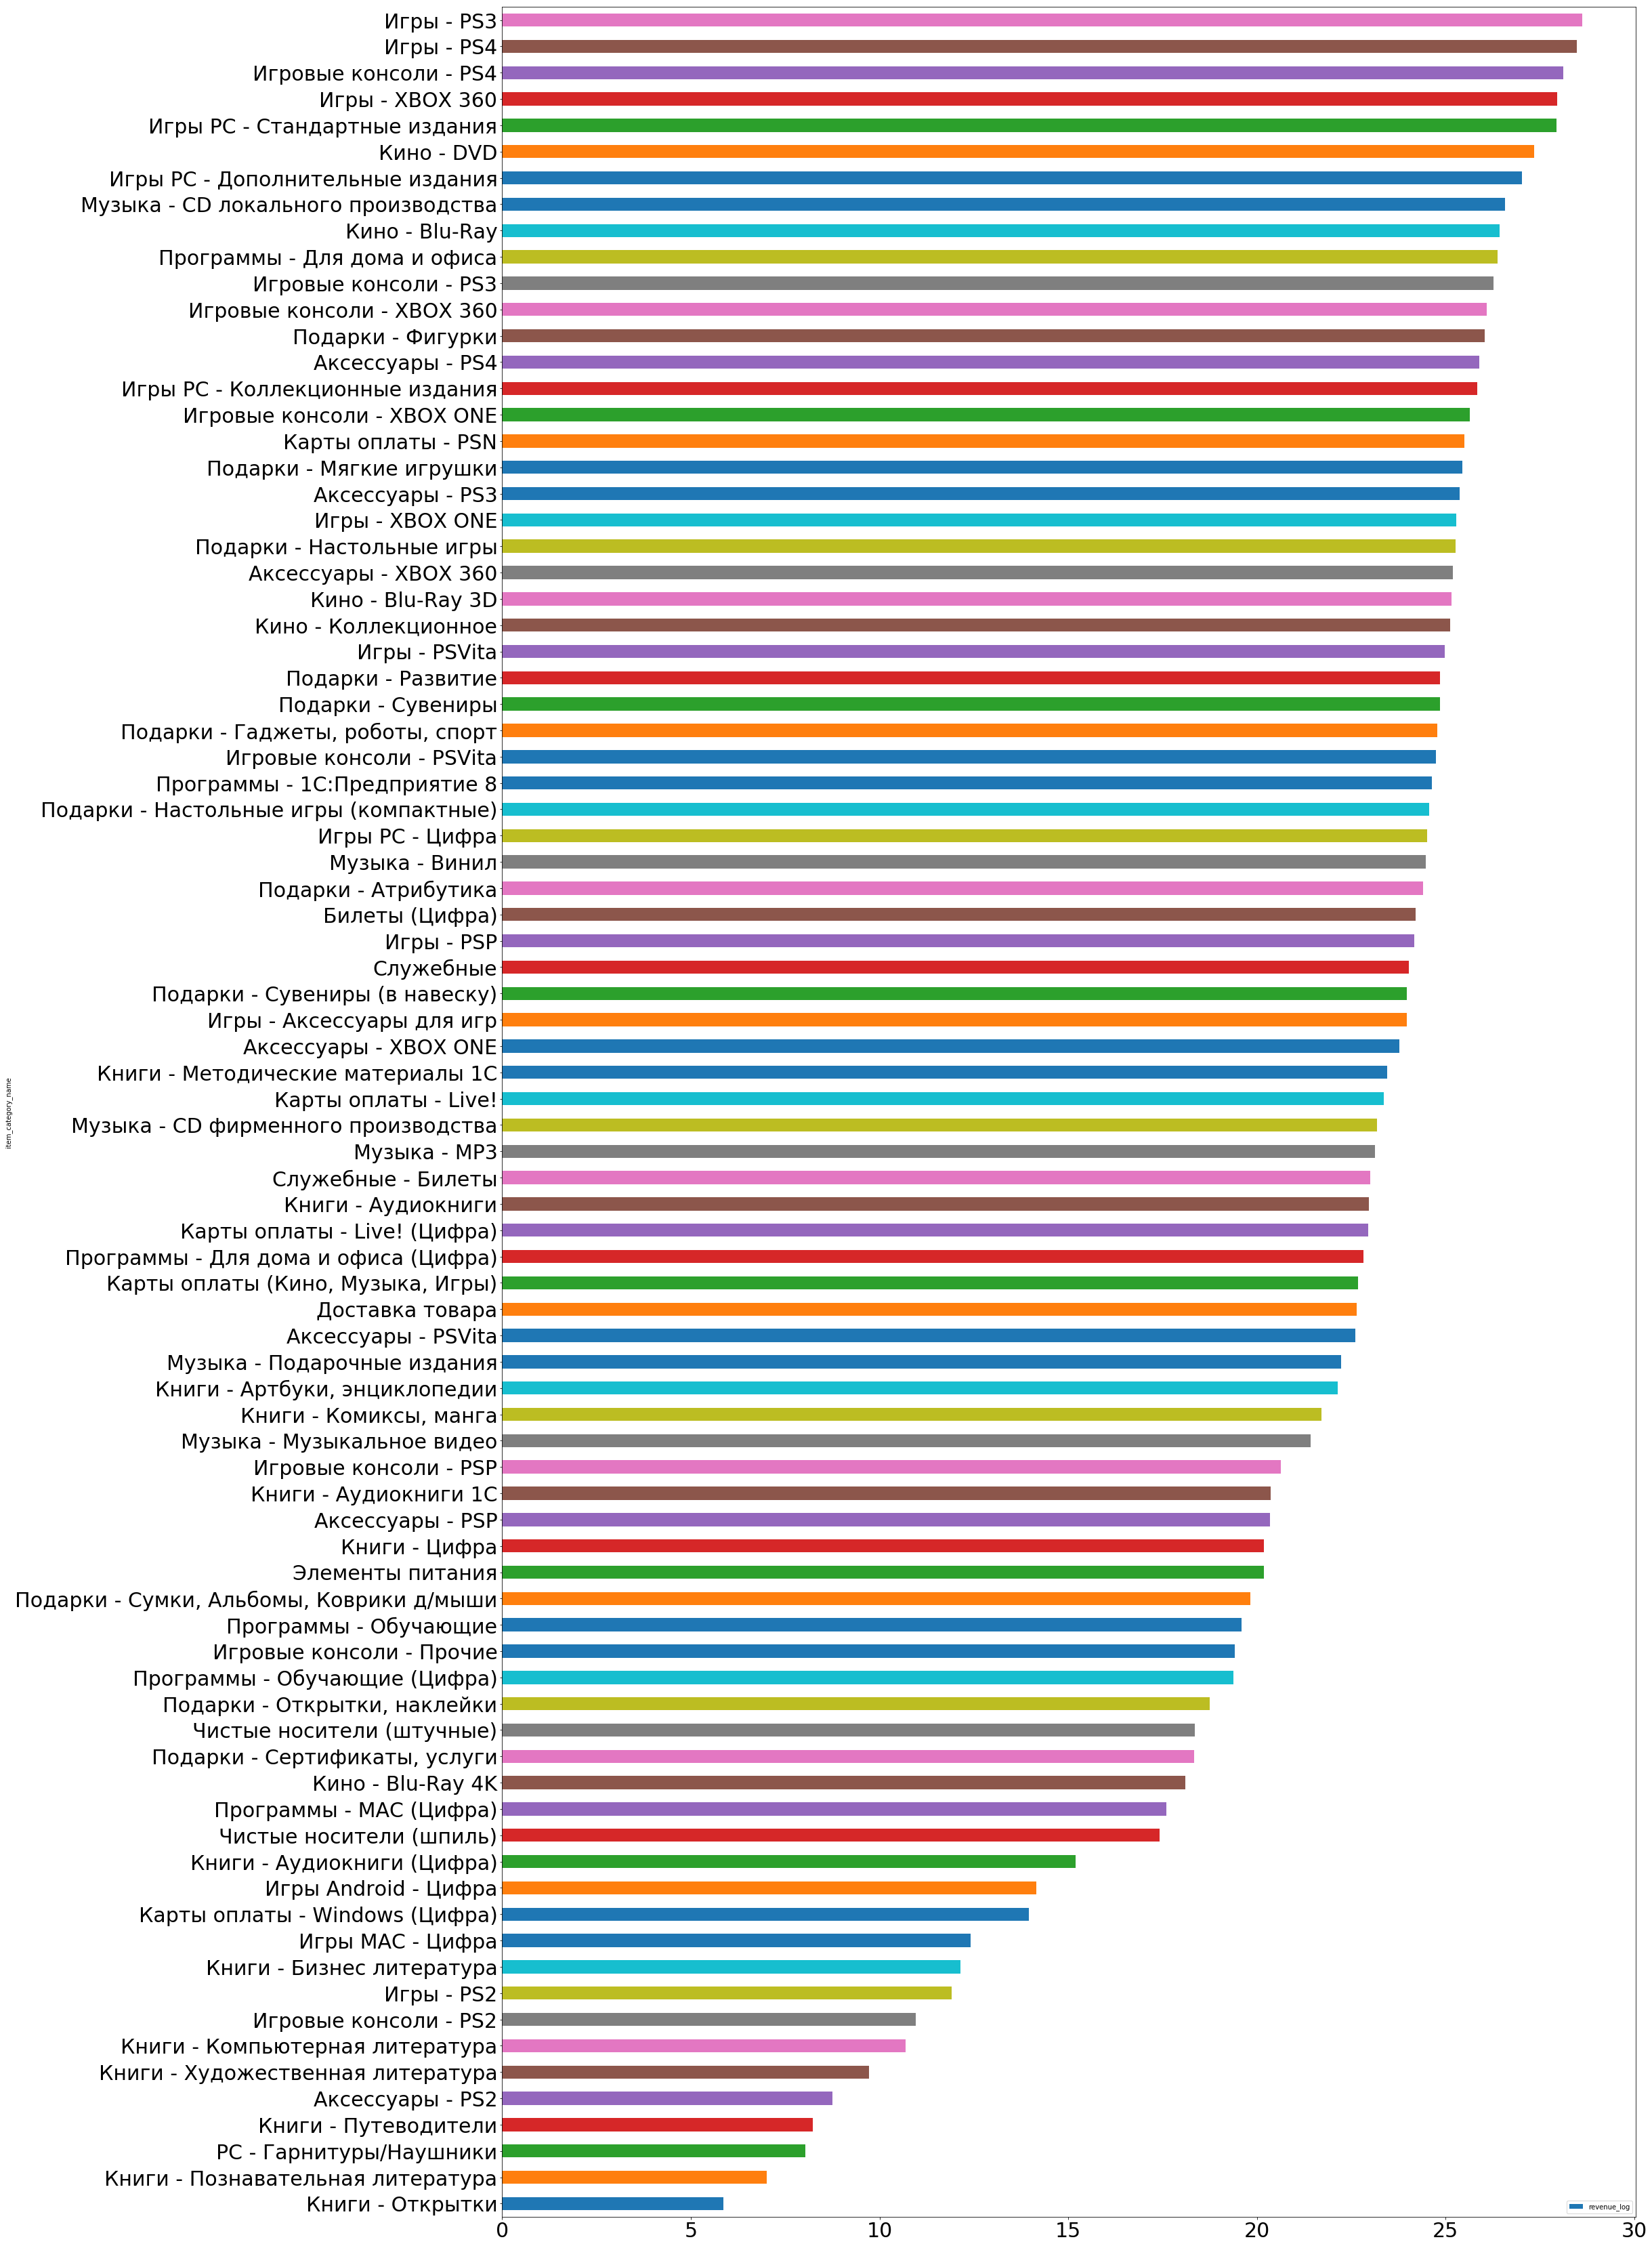

In [ ]:
sales_train['category_id'] = sales_train['item_id'].map(itemid2cat).fillna('none')

revenue_by_category = sales_train['item_revenue'].groupby(sales_train['category_id']).sum()

item_categories.item_category_name
item_categories['revenue']    = revenue_by_category
item_categories['revenue_log'] = np.log2(item_categories['revenue'])

display(item_categories)

ax = item_categories.sort_values(by=['revenue']).plot.barh( x = 'item_category_name',
                                    y='revenue_log',
                                   figsize  = (30,60),
                                  fontsize = 30)
# display(revenue_by_category)

,item_category_name,item_category_id,item_metacategory_name,item_metacategory_id,revenue,revenue_log,price_mean
71,"Подарки - Сумки, Альбомы, Коврики д/мыши",71,Подарки,13,9.342066e+05,19.833382,4.931371
50,Книги - Открытки,50,Книги,11,5.800000e+01,5.857981,20.500000
82,Чистые носители (штучные),82,Чистые носители,16,3.362661e+05,18.359244,32.481014
66,"Подарки - Открытки, наклейки",66,Подарки,13,4.423453e+05,18.754813,76.778940
0,PC - Гарнитуры/Наушники,0,PC,0,2.634000e+02,8.041112,87.800000
52,Книги - Путеводители,52,Книги,11,3.000000e+02,8.228819,100.000000
83,Элементы питания,83,Элементы питания,17,1.189234e+06,20.181601,100.280925
51,Книги - Познавательная литература,51,Книги,11,1.290000e+02,7.011227,129.000000
44,Книги - Аудиокниги (Цифра),44,Книги,11,3.761900e+04,15.199174,149.516129
26,Игры Android - Цифра,26,Игры Android,6,1.831980e+04,14.161116,162.907692


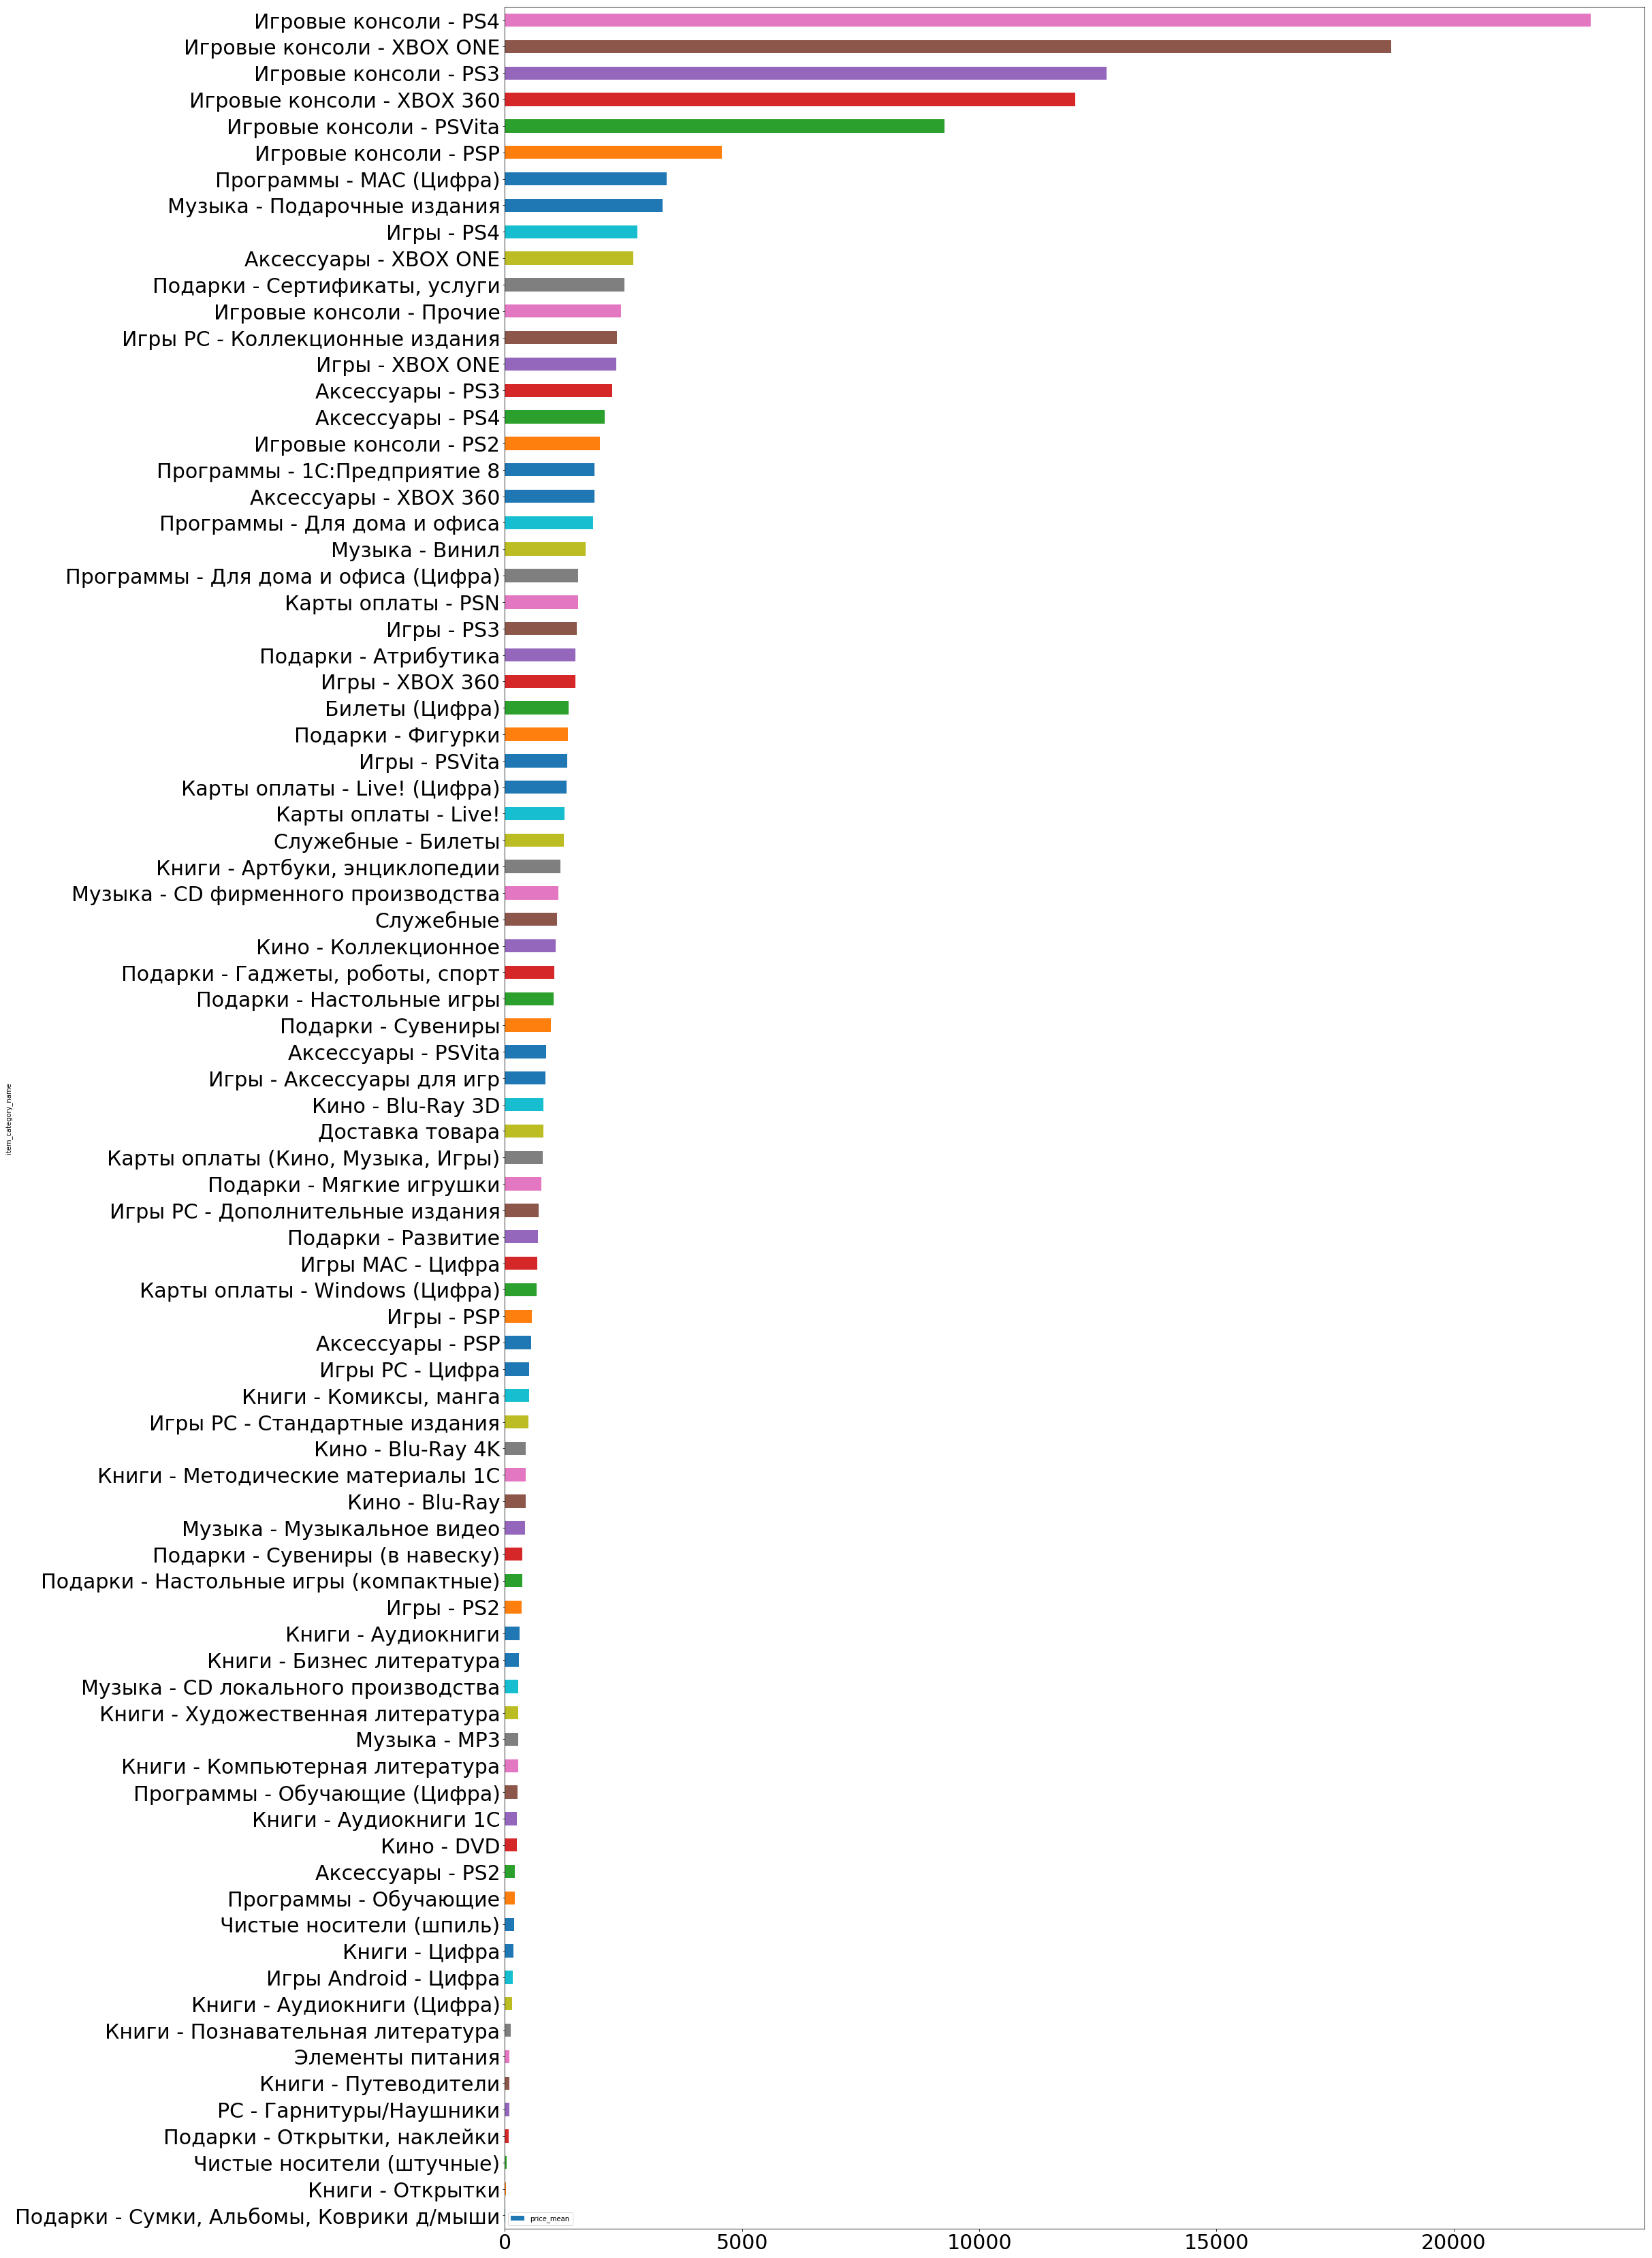

In [ ]:
# Calc average price in category

price_by_category = sales_train['item_price'].groupby(sales_train['category_id']).mean()

item_categories['price_mean']    = price_by_category

ax = item_categories.sort_values(by=['price_mean']).plot.barh( x = 'item_category_name',
                                    y='price_mean',
                                   figsize  = (30,60),
                                  fontsize = 30)
display(item_categories.sort_values(by=['price_mean']))

Sounds reasonable - the most expensive category is gaming consoles, the cheapest - postcards and blank CD

## Search for leakages

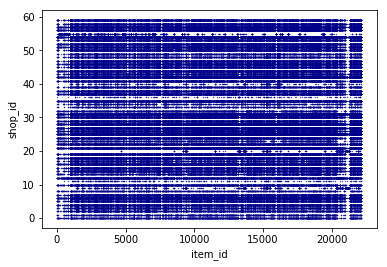

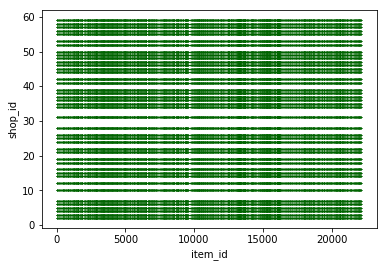

In [ ]:
sales_train.drop_duplicates(subset=['item_id', 'shop_id']).plot.scatter('item_id', 'shop_id', color='DarkBlue', s = 0.1)
test.drop_duplicates(subset=['item_id', 'shop_id']).plot.scatter('item_id', 'shop_id', color='DarkGreen', s = 0.1)



In [ ]:
print('%2d shops are used in test /%4d in train'% ( len(test.shop_id.unique()),len(sales_train.shop_id.unique())))
print('%2d items_id are used in test /%4d in train'% ( len(test.item_id.unique()),len(sales_train.item_id.unique())))


42 shops are used in test /  60 in train
5100 items_id are used in test /21806 in train


In [ ]:
shops.loc[test.shop_id.unique()]

,shop_name,shop_id,shop_city,shop_city_id,shop_city_pop,shop_city_subj,shop_city_subj_id
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,2,301642.0,Вологодская область,3
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,1,314436.0,Волгоградская область,2
6,"Воронеж (Плехановская, 13)",6,Воронеж,3,889680.0,Воронежская область,4
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,0,215353.0,Московская область,10
2,"Адыгея ТЦ ""Мега""",2,Краснодар,10,744933.0,Краснодарский край,6
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,3,889680.0,Воронежская область,4
10,Жуковский ул. Чкалова 39м²,10,Жуковский,5,102729.0,Московская область,10
12,Интернет-магазин ЧС,12,Интернет-магазин,6,-1.0,not-a-city,0
28,"Москва ТЦ ""МЕГА Теплый Стан"" II",28,Москва,13,11514330.0,Москва,9
31,"Москва ТЦ ""Семеновский""",31,Москва,13,11514330.0,Москва,9


#### So distribution are representative, used both big cities and small ones

# Data aggregation

Method for data aggregation was proposed by team. 

We should transform train data set  history of transactions to "shop-item_id" prediction for specific month.

So we need
* Group by test-columns, 'date_block_num','shop_id','item_id'
* Aggregate columns
    * Count aggregate as sum
    * Price aggregate by mean

In [ ]:
test.merge(sales_train, how='left', on=['shop_id', 'item_id']).isnull().sum()

test.shape[0]

214200

In [ ]:
sales_train.head(5)
sales_train_m = sales_train.groupby(['date_block_num','shop_id','item_id'])
sales_train_m = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': 'sum','item_price': np.mean}).reset_index()
#sales_train_m = pd.merge(grid,sales_train_m,on=['date_block_num','shop_id','item_id'],how='left').fillna(0)
def df_expand_with_items_and_shops(df):
    df = pd.merge(df, items,           on=['item_id']          ,how='left')
    df = pd.merge(df, item_categories, on=['item_category_id'], how='left')
    df = pd.merge(df, shops          , on=['shop_id']         , how='left')
    return df
sales_train_m = df_expand_with_items_and_shops(sales_train_m)
display(sales_train_m.sample(50))
display(sales_train_m.sample(50))
display(sales_train_m.head(50))

,date_block_num,shop_id,item_id,item_cnt_day,item_price,item_name,item_category_id,item_category_name,item_metacategory_name,item_metacategory_id,revenue,revenue_log,price_mean,shop_name,shop_city,shop_city_id,shop_city_pop,shop_city_subj,shop_city_subj_id
9197,0,7,18613,1.0,149.0,СЕКС ПО ДРУЖБЕ (регион),40,Кино - DVD,Кино,10,1.699442e+08,27.340486,256.339150,"Воронеж ТРЦ ""Максимир""",Воронеж,3,889680.0,Воронежская область,4
936978,17,16,21968,1.0,639.0,Шар-лабиринт Лабиринтус 19см 138 шагов,67,Подарки - Развитие,Подарки,13,3.037514e+07,24.856388,692.268441,"Коломна ТЦ ""Рио""",Коломна,9,144642.0,Московская область,10
871199,15,47,18833,1.0,199.0,СМЕШАРИКИ НОВЫЕ ПРИКЛЮЧЕНИЯ Выпуск 7 Добрая...,40,Кино - DVD,Кино,10,1.699442e+08,27.340486,256.339150,"Сургут ТРЦ ""Сити Молл""",Сургут,22,306703.0,Ханты-Мансийский АО — Югра,20
247109,4,12,1409,1.0,699.0,"Anarchy Reigns. Limited Edition [PS3, русская ...",19,Игры - PS3,Игры,5,4.120503e+08,28.618245,1512.044319,Интернет-магазин ЧС,Интернет-магазин,6,-1.0,not-a-city,0
544383,9,30,21825,1.0,399.0,ШЕВЕЛИ ЛАСТАМИ 2,40,Кино - DVD,Кино,10,1.699442e+08,27.340486,256.339150,"Москва ТЦ ""Перловский""",Москва,13,11514330.0,Москва,9
1435372,28,35,11169,1.0,28.0,ДОМ С ПАРАНОРМАЛЬНЫМИ ЯВЛЕНИЯМИ,40,Кино - DVD,Кино,10,1.699442e+08,27.340486,256.339150,"Н.Новгород ТРЦ ""Фантастика""",Нижний Новгород,15,1250615.0,Нижегородская область,11
1260443,24,12,2878,0.0,3499.0,Disney. Infinity 2.0 (Marvel). Стартовый набор...,23,Игры - XBOX 360,Игры,5,2.596191e+08,27.951821,1479.293863,Интернет-магазин ЧС,Интернет-магазин,6,-1.0,not-a-city,0
1534713,31,41,5039,3.0,749.0,"NHL 15 [Xbox 360, русские субтитры]",23,Игры - XBOX 360,Игры,5,2.596191e+08,27.951821,1479.293863,"РостовНаДону ТЦ ""Мега""",Ростов-на-Дону,18,1091544.0,Ростовская область,14
1488155,30,19,2734,1.0,699.0,"Dead Island. Полное издание [PS3, английская в...",19,Игры - PS3,Игры,5,4.120503e+08,28.618245,1512.044319,"Курск ТЦ ""Пушкинский""",Курск,12,414595.0,Курская область,8
1496408,30,31,313,2.0,249.0,1С:Аудиокниги. Марк Твен. Приключения Тома Сой...,45,Книги - Аудиокниги 1С,Книги,11,1.348073e+06,20.362467,257.398109,"Москва ТЦ ""Семеновский""",Москва,13,11514330.0,Москва,9


,date_block_num,shop_id,item_id,item_cnt_day,item_price,item_name,item_category_id,item_category_name,item_metacategory_name,item_metacategory_id,revenue,revenue_log,price_mean,shop_name,shop_city,shop_city_id,shop_city_pop,shop_city_subj,shop_city_subj_id
1280578,24,35,7780,2.0,699.000000,"Wasteland 2 [PC, русская версия]",30,Игры PC - Стандартные издания,Игры PC,8,2.575193e+08,27.940105,499.199532,"Н.Новгород ТРЦ ""Фантастика""",Нижний Новгород,15,1250615.0,Нижегородская область,11
664099,11,42,11593,4.0,999.000000,ЗАКЛЯТИЕ (BD),37,Кино - Blu-Ray,Кино,10,9.047873e+07,26.431075,434.289667,"СПб ТК ""Невский Центр""",Санкт-Петербург,20,4848742.0,Санкт-Петербург,16
866565,15,42,11921,5.0,549.000000,ИГРА ПРЕСТОЛОВ. СЕЗОН 1 (5 DVD),40,Кино - DVD,Кино,10,1.699442e+08,27.340486,256.339150,"СПб ТК ""Невский Центр""",Санкт-Петербург,20,4848742.0,Санкт-Петербург,16
1309585,25,16,18942,1.0,99.000000,СОБАКА НА СЕНЕ (регион),40,Кино - DVD,Кино,10,1.699442e+08,27.340486,256.339150,"Коломна ТЦ ""Рио""",Коломна,9,144642.0,Московская область,10
367074,6,22,4769,2.0,449.000000,"Mars: War Logs [PC, Jewel, русские субтитры]",30,Игры PC - Стандартные издания,Игры PC,8,2.575193e+08,27.940105,499.199532,Москва Магазин С21,Москва,13,11514330.0,Москва,9
525161,9,12,3732,23.0,2568.722222,"Grand Theft Auto V [PS3, русские субтитры]",19,Игры - PS3,Игры,5,4.120503e+08,28.618245,1512.044319,Интернет-магазин ЧС,Интернет-магазин,6,-1.0,not-a-city,0
1026258,19,12,11365,5.0,859.166667,Доставка (EMS),9,Доставка товара,Доставка товара,3,6.538910e+06,22.640619,814.342848,Интернет-магазин ЧС,Интернет-магазин,6,-1.0,not-a-city,0
1360228,26,28,10740,1.0,99.000000,ДВА ДНЯ (BD),37,Кино - Blu-Ray,Кино,10,9.047873e+07,26.431075,434.289667,"Москва ТЦ ""МЕГА Теплый Стан"" II",Москва,13,11514330.0,Москва,9
17742,0,19,2635,1.0,299.000000,DIRE STRAITS Sultans Of Swing,55,Музыка - CD локального производства,Музыка,12,1.000226e+08,26.575750,286.209370,"Курск ТЦ ""Пушкинский""",Курск,12,414595.0,Курская область,8
333090,5,44,10008,1.0,149.000000,ВОЛШЕБНЫЙ МЕЧ (регион) WB,40,Кино - DVD,Кино,10,1.699442e+08,27.340486,256.339150,"Самара ТЦ ""Мелодия""",Самара,19,1164900.0,Самарская область,15


,date_block_num,shop_id,item_id,item_cnt_day,item_price,item_name,item_category_id,item_category_name,item_metacategory_name,item_metacategory_id,revenue,revenue_log,price_mean,shop_name,shop_city,shop_city_id,shop_city_pop,shop_city_subj,shop_city_subj_id
0,0,0,32,6.0,221.0,1+1,40,Кино - DVD,Кино,10,1.699442e+08,27.340486,256.339150,"Якутск Орджоникидзе, 56 фран",Якутск,28,269486.0,Якутия,21
1,0,0,33,3.0,347.0,1+1 (BD),37,Кино - Blu-Ray,Кино,10,9.047873e+07,26.431075,434.289667,"Якутск Орджоникидзе, 56 фран",Якутск,28,269486.0,Якутия,21
2,0,0,35,1.0,247.0,10 ЛЕТ СПУСТЯ,40,Кино - DVD,Кино,10,1.699442e+08,27.340486,256.339150,"Якутск Орджоникидзе, 56 фран",Якутск,28,269486.0,Якутия,21
3,0,0,43,1.0,221.0,100 МИЛЛИОНОВ ЕВРО,40,Кино - DVD,Кино,10,1.699442e+08,27.340486,256.339150,"Якутск Орджоникидзе, 56 фран",Якутск,28,269486.0,Якутия,21
4,0,0,51,2.0,128.5,100 лучших произведений классики (mp3-CD) (Dig...,57,Музыка - MP3,Музыка,12,9.199030e+06,23.133050,281.540490,"Якутск Орджоникидзе, 56 фран",Якутск,28,269486.0,Якутия,21
5,0,0,61,1.0,195.0,1000 и одна ночь 2CD (mp3-DVD) (DVD-Book),43,Книги - Аудиокниги,Книги,11,8.218004e+06,22.970357,308.835175,"Якутск Орджоникидзе, 56 фран",Якутск,28,269486.0,Якутия,21
6,0,0,75,1.0,76.0,12 ДРУЗЕЙ ОУШЕНА WB (регион),40,Кино - DVD,Кино,10,1.699442e+08,27.340486,256.339150,"Якутск Орджоникидзе, 56 фран",Якутск,28,269486.0,Якутия,21
7,0,0,88,1.0,76.0,13 ДРУЗЕЙ ОУШЕНА WB (регион),40,Кино - DVD,Кино,10,1.699442e+08,27.340486,256.339150,"Якутск Орджоникидзе, 56 фран",Якутск,28,269486.0,Якутия,21
8,0,0,95,1.0,193.0,1812. ЭНЦИКЛОПЕДИЯ ВЕЛИКОЙ ВОЙНЫ,40,Кино - DVD,Кино,10,1.699442e+08,27.340486,256.339150,"Якутск Орджоникидзе, 56 фран",Якутск,28,269486.0,Якутия,21
9,0,0,96,1.0,70.0,1812. ЭНЦИКЛОПЕДИЯ ВОЙНЫ (регион),40,Кино - DVD,Кино,10,1.699442e+08,27.340486,256.339150,"Якутск Орджоникидзе, 56 фран",Якутск,28,269486.0,Якутия,21


# Mean encoding

Mean encoding on all category data which are item_id, shop_id and item_category_id

In [ ]:
if 1:
    for type_id in ['item_id','shop_id','item_category_id']:
        for column_id, agg_func, func_name in [ ('item_price'  , np.mean ,'avg'),
                                                ('item_cnt_day', np.sum  ,'sum'),
                                                ('item_cnt_day', np.mean ,'avg')]:

            mean_df = sales_train_m.groupby([type_id,'date_block_num']).agg(agg_func).reset_index()[[column_id,type_id,'date_block_num']]
            mean_df.columns = [type_id+'_'+func_name+'_'+column_id, type_id,'date_block_num']

            sales_train_m = pd.merge(sales_train_m,mean_df,on=['date_block_num', type_id],how='left')

In [ ]:
display(sales_train_m)

In [ ]:
temp_test = test.copy()
temp_test['date_block_num'] = 34
temp_test.drop('ID', axis=1, inplace=True)
temp_test = df_expand_with_items_and_shops(temp_test)
display(temp_test)


In [ ]:
# temp_test.drop(    'item_name', axis=1, inplace=True)
# sales_train_m.drop('item_name', axis=1, inplace=True)
#sales_train_m = pd.concat([sales_train_m,temp_test], axis=0, ignore_index=True)
print('Before %d :'%len(sales_train_m))
if 0:
    sales_train_m = sales_train_m.append(temp_test, ignore_index=True)
print('After  %d :'%len(sales_train_m))
    


In [ ]:

display(sales_train_m)

In [ ]:
if 1:
    lag_variables  = ['item_id_avg_item_price',
    'item_id_sum_item_cnt_day',
    'item_id_avg_item_cnt_day',
    'shop_id_avg_item_price',
    'shop_id_sum_item_cnt_day',
    'shop_id_avg_item_cnt_day',
    'item_category_id_avg_item_price',
    'item_category_id_sum_item_cnt_day',
    'item_category_id_avg_item_cnt_day',
    'item_cnt_day']

    #Limited by computation resource
    lags = [1]
    #lags = [1, 2, 3, 4, 5, 6, 9, 12]

    for lag in lags:
        sales_new_df = sales_train_m.copy()
        sales_new_df.date_block_num+=lag
        sales_new_df = sales_new_df[['date_block_num','shop_id','item_id']+lag_variables]
        sales_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
        sales_train_m = sales_train_m.merge(sales_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')

In [ ]:
display(sales_train_m)

In [ ]:
def sales_fillna(df):
    for feat in df.columns:
        if 'item_cnt' in feat:
            df[feat]=df[feat].fillna(0)
        elif 'item_price' in feat:
            df[feat]=df[feat].fillna(df[feat].median())
if 1:
    sales_fillna(sales_train_m)

In [ ]:
display(sales_train_m)

In [ ]:
#cols_to_drop = lag_variables[:-1] + ['item_price']
#sales_train_m = sales_train_m[sales_train_m['date_block_num']>12]

In [ ]:
X_train = sales_train_m[sales_train_m['date_block_num'] <  33]
X_cv    = sales_train_m[sales_train_m['date_block_num'] == 33]
X_test  = sales_train_m[sales_train_m['date_block_num'] == 34]


In [ ]:
print(len(X_train))
print(len(X_cv))
print(len(X_test))
display(X_train)
display(X_test)

In [ ]:
X_train['item_cnt_day'].clip_upper(40, inplace=True)
X_train['item_cnt_day'].clip_lower(0, inplace=True)

X_cv['item_cnt_day'].clip_upper(40, inplace=True)
X_cv['item_cnt_day'].clip_lower(0, inplace=True)

X_test['item_cnt_day'].clip_upper(40, inplace=True)
X_test['item_cnt_day'].clip_lower(0, inplace=True)

In [ ]:
if 0:
    X_train.to_csv('X_train.csv',   index=False)
    X_cv.to_csv('X_cv.csv',         index=False)
    X_test.to_csv('X_test.csv',     index=False)


# P2. Model training

In [ ]:
if 0:
    f='../data/'
    test     = pd.read_csv(f+'test.csv.gz')
    X_train  = pd.read_csv('X_train.csv')
    X_cv     = pd.read_csv('X_cv.csv')
    X_test   = pd.read_csv('X_test.csv')


In [ ]:
params = {
        'eta': 0.08, #best 0.08
        'max_depth': 7,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'seed': 3,
        'gamma':1,
        'silent': False
    }

In [ ]:
cols_to_drop = [
       'date_block_num'
    , 'item_cnt_day'
    , 'item_name'
    , 'item_category_name'
    , 'item_metacategory_name'
    , 'shop_name'
    , 'shop_city'
    , 'shop_city_subj'
]
cols = [c for c in X_train.columns if c not in cols_to_drop]

x1 = X_train[cols]
y1 = X_train['item_cnt_day']
x2 = X_cv[cols]
y2 = X_cv['item_cnt_day']

watchlist = [ (xgb.DMatrix(x1, y1), 'train'),
              (xgb.DMatrix(x2, y2), 'valid')]

model = xgb.train( params, 
                   xgb.DMatrix(x1, y1), 
                   3500,  
                   watchlist, 
                   maximize=False, 
                   verbose_eval=50, 
                   early_stopping_rounds=50 )

In [ ]:
import pickle

In [ ]:
pickle.dump(model, open("xgb.pickle.dat", "wb"))
if 0:
    model = pickle.load(open("pima.pickle.dat", "rb"))

pred = model.predict(xgb.DMatrix(X_test[cols]), ntree_limit=model.best_ntree_limit)



In [ ]:
len(pred)

In [ ]:
test['item_cnt_month'] = pred.clip(0,20)
test.drop(['shop_id', 'item_id'], axis=1, inplace=True)
test.to_csv('submission.csv', index=False)